# 0.0. IMPORTS

In [67]:
import numpy               as np
import pandas              as pd
import seaborn             as sns
import matplotlib.pyplot   as plt
import inflection
import math

from boruta                import BorutaPy
from IPython.display       import Image
from datetime              import datetime
from datetime              import timedelta
from matplotlib            import gridspec
from tabulate              import tabulate
from scipy                 import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor

## 0.1. Helper Functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1) * (r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = (20,8)
    plt.rcParams['font.size'] = 24
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\Arbo\anaconda3\envs\rossman-predict-sales\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.2. Loading data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3. Data types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
#competition_distance
# Assumimos uma assumption, onde farmacias que não contem competidor proximo, ao inves de retornar um valor NaN, retornar uma distancia maior que o valor max
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
# Se o valor == NaN, quer dizer que ou a loja nao tem competidores ou não tem uma data de registro de abertura da competição
# Assumption: será inserido o mês e o ano da data de registro da venda, pois na avaliação do algoritmo, esse atributo pode ser importantes para responder a alta ou baixa no valor de venda, nesse sentido, vamos assumir essa premissa para analisar os resultados
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include=['int64','float64'])

cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [15]:
# Central tedency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concat

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.1. Categorical Attributes

In [16]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [17]:
aux = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

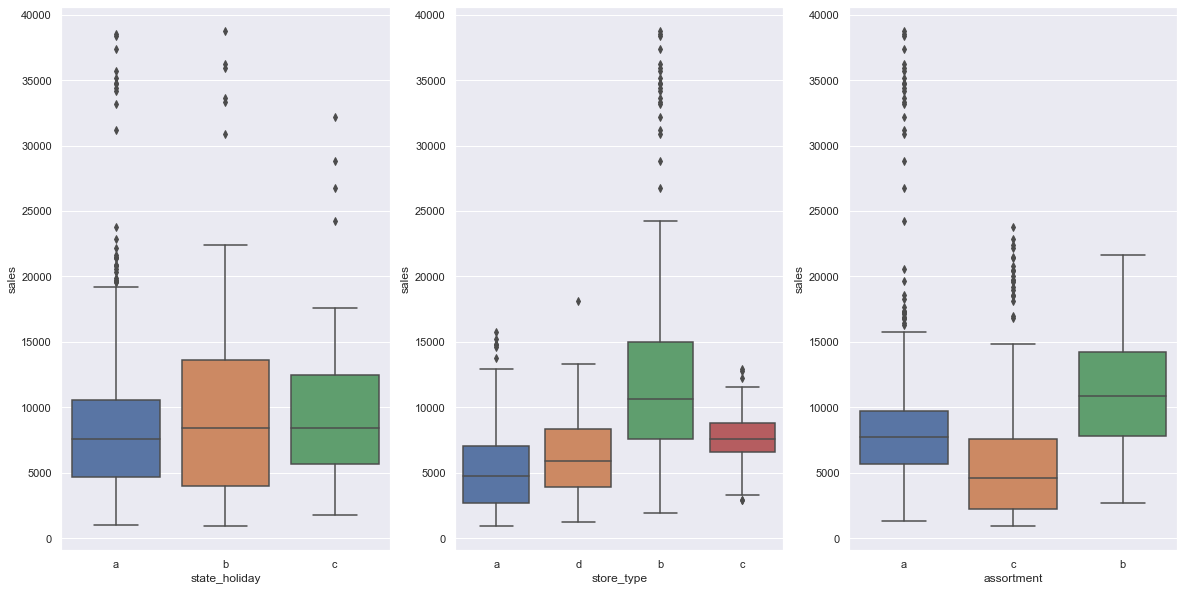

In [18]:
plt.figure(figsize=[20,10])
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales', data=aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales', data=aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales', data=aux)

# 2.0. FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

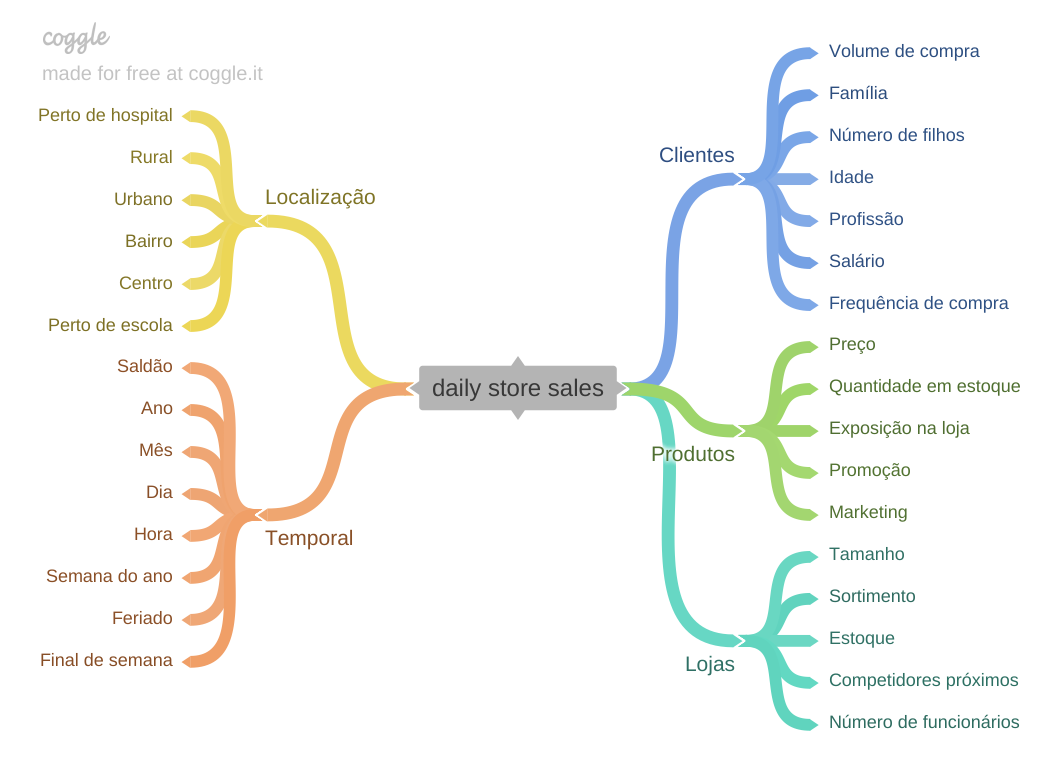

In [20]:
Image('img\MindMapHyphothesesRossman.png')

## 2.2. Criação de Hipóteses

### 2.2.1. Hipóteses da Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com competidores mais próximos deveriam vender menos.

**5.** Lojas com competidores a mais tempo deveriam vender mais.

**6.** Lojas com maior sortimento deveriam vender mais.

### 2.2.2. Hipóteses da Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais seus produtos na vitrine deveriam vender mais.

**3.** Lojas com preços menores nos produtos deveriam vender mais.

**4.** Lojas com preços menores por mais tempo deveriam vender mais.

**5.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipóteses da Tempo

**1.** Lojas que mais fecham em feriados deveriam vender menos.

**2.** Lojas que permanecem abertas mais dias na semana deveriam vendem mais.

**3.** Lojas que abrem nos finais de semana deveriam vender menos.

**4.** Lojas que abrem durante o natal deveriam vender mais.

**5.** Lojas deveriam vender mais ao longo dos anos.

**6.** Lojas deveriam vender mais no segundo semestro do ano.

**7.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**8.** Lojas deveriam vender menos durante feriados escolares.

### 2.2.4. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas que abrem durante o natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestro do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas que abrem nos finais de semana deveriam vender menos.

**12.** Lojas deveriam vender menos durante feriados escolares.

## 2.3. Feature Engineering

In [21]:
#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
#year week
#df2['week_of_year'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')
#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

#assortments
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. FILTERING VARIABLES

In [22]:
df3 = df2.copy()

## 3.1. Filtering rows

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtering columns

In [24]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. EXPLORATION DATA ANALISYS

In [25]:
df4 = df3.copy()

## 4.1. Univariate Analisys

### 4.1.1. Response Variable

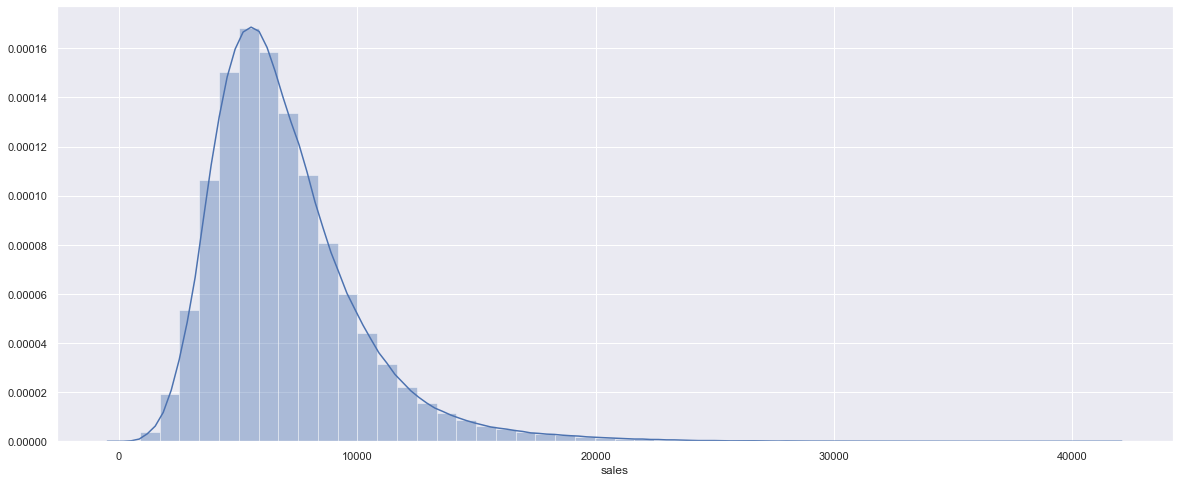

In [26]:
sns.distplot(df4['sales']);

### 4.1.1. Numerical Variable

In [27]:
num_attributes2 = df3.select_dtypes(include=['int64','float64'])

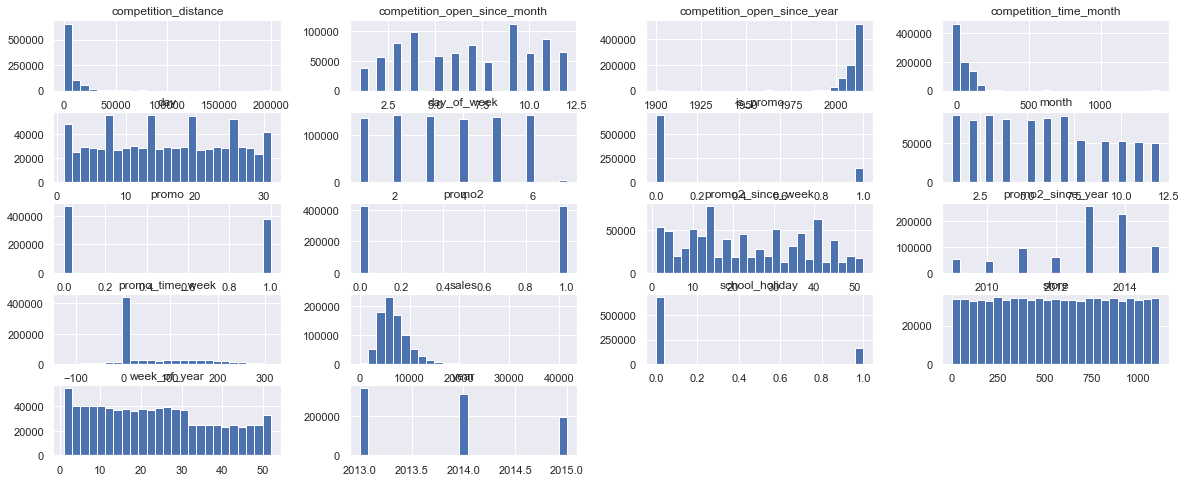

In [28]:
#Explicar cada plot, causa e efeito, uma resposta para um possível comportamento
num_attributes2.hist(bins=25);

### 4.1.1. Categorical Variable

In [29]:
cat_attributes2 = df3.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

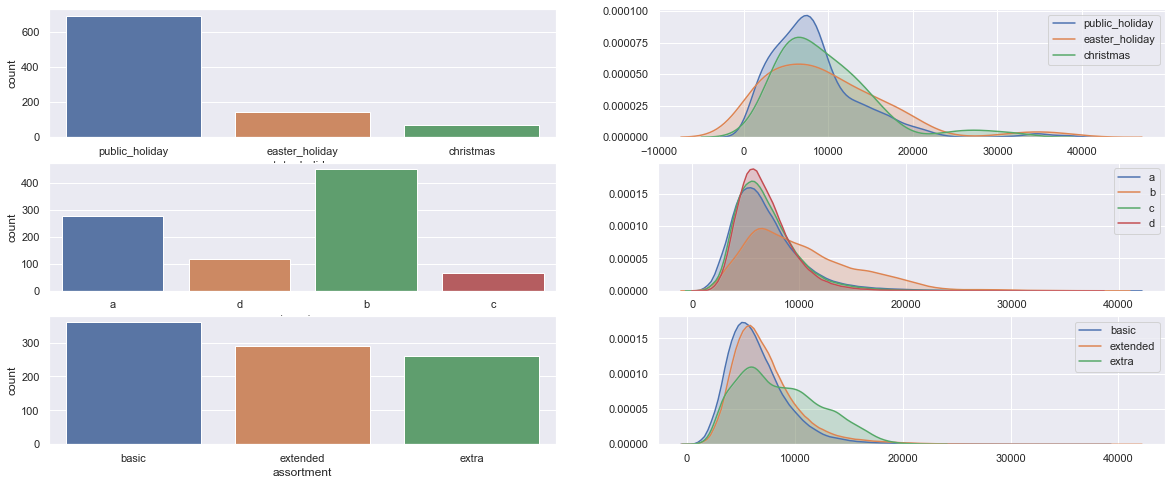

In [30]:
#state holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type
plt.subplot(3,2,3)
sns.countplot(a['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment
plt.subplot(3,2,5)
sns.countplot(a['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2. Bivariate Analisys

### 4.2.1. Hyopotheses Validation

#### **H1.** Lojas com maior sortimento deveriam vender mais.
**True**

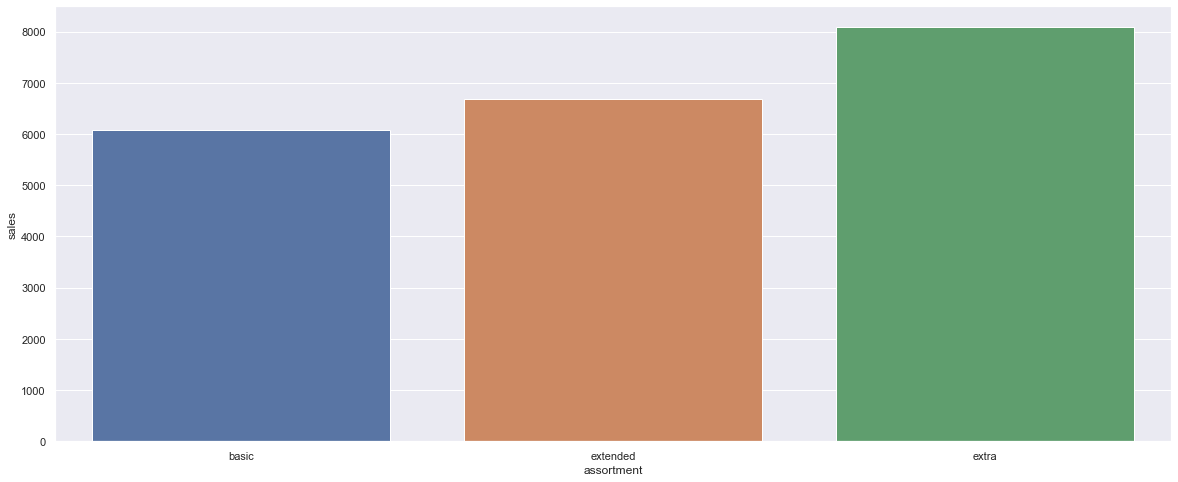

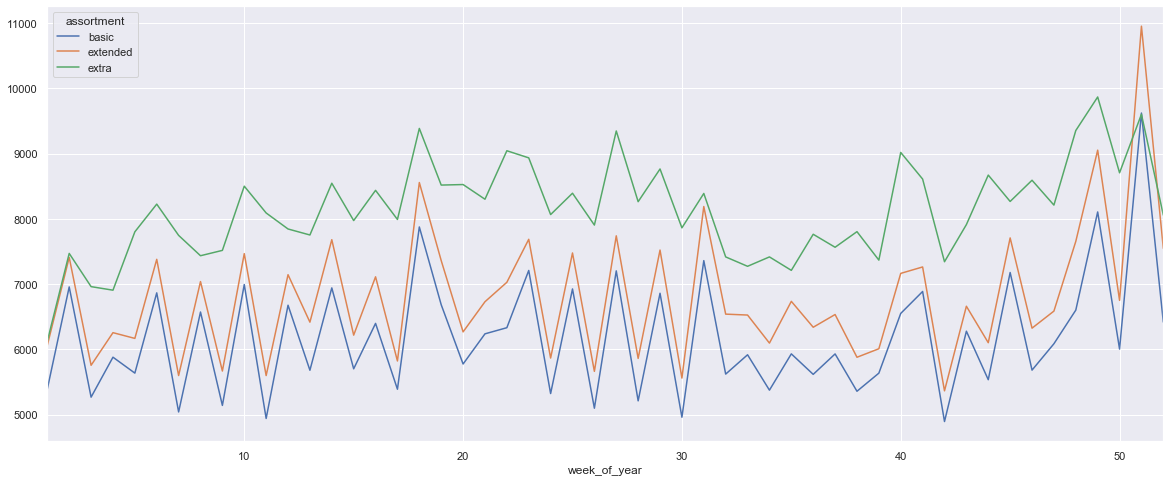

In [31]:
aux1 = df4[['assortment','sales']].groupby('assortment').median().reset_index()
sns.barplot(x='assortment',y='sales', data=aux1);

aux2 = df4[['week_of_year','assortment','sales']].groupby(['week_of_year','assortment']).median().reset_index()
aux2.pivot(index='week_of_year',columns='assortment',values='sales').plot();

#### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**False** A relação de venda com a distância de competidores não se correlacionam.

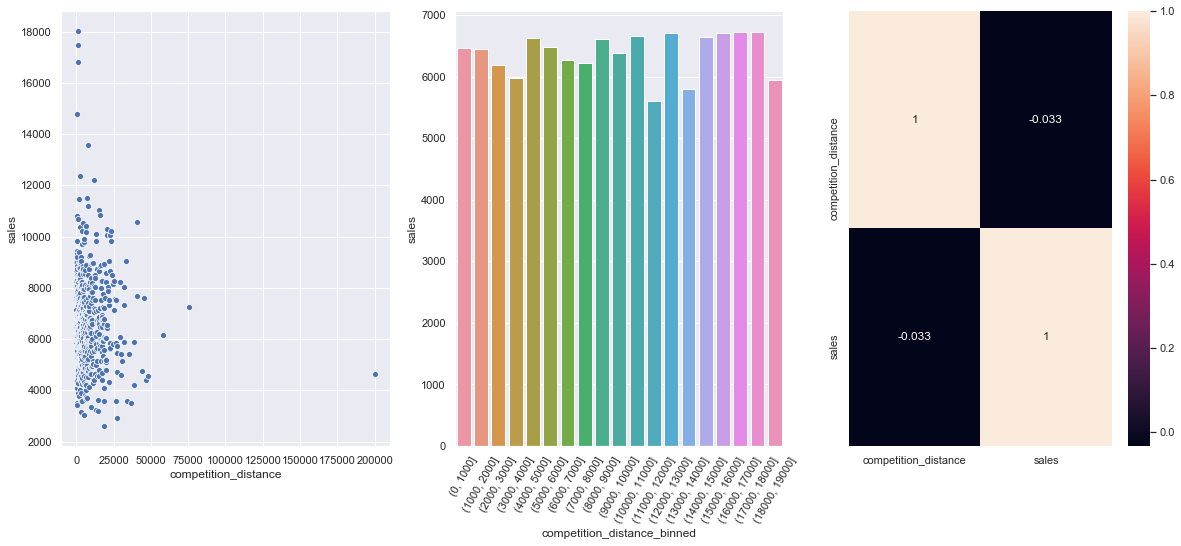

In [32]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').median().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').median().reset_index()

plt.subplot(1,3,2)
plt.xticks(rotation=60)
sns.barplot(x='competition_distance_binned',y='sales',data=aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### **H3.** Lojas com competidores a mais tempo deveriam vender mais.
**False** Lojas com competidores a mais tempo vedem menos

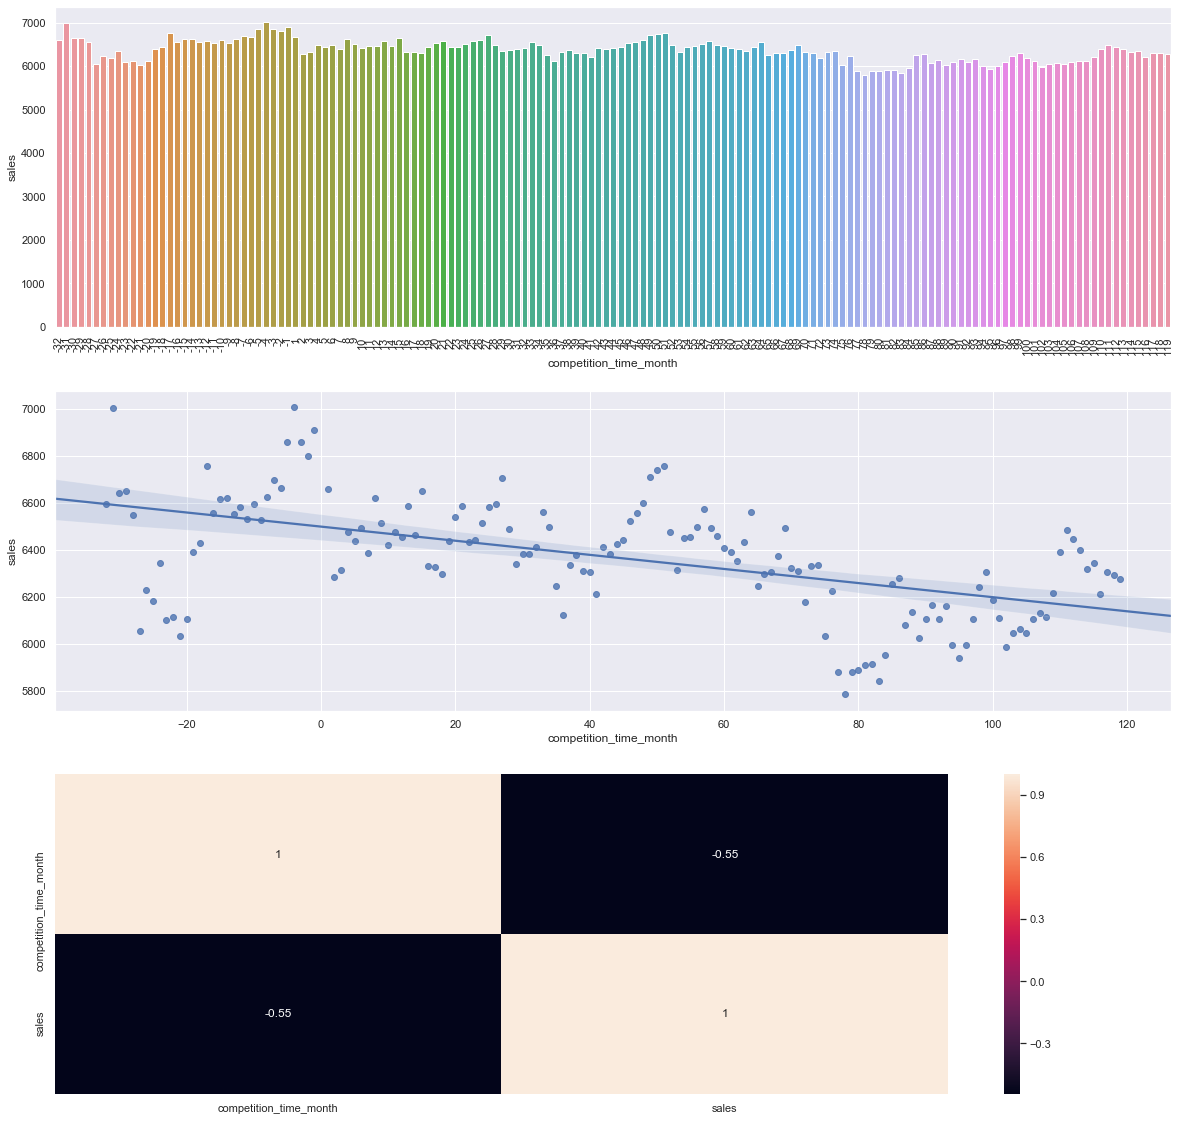

In [33]:
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').median().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0)]

plt.figure(figsize=[20,20])

plt.subplot(3,1,1)
plt.xticks(rotation=90)
sns.barplot(x='competition_time_month',y='sales', data=aux2)

plt.subplot(3,1,2)
sns.regplot(x='competition_time_month',y='sales', data=aux2);

plt.subplot(3,1,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

#### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**True**

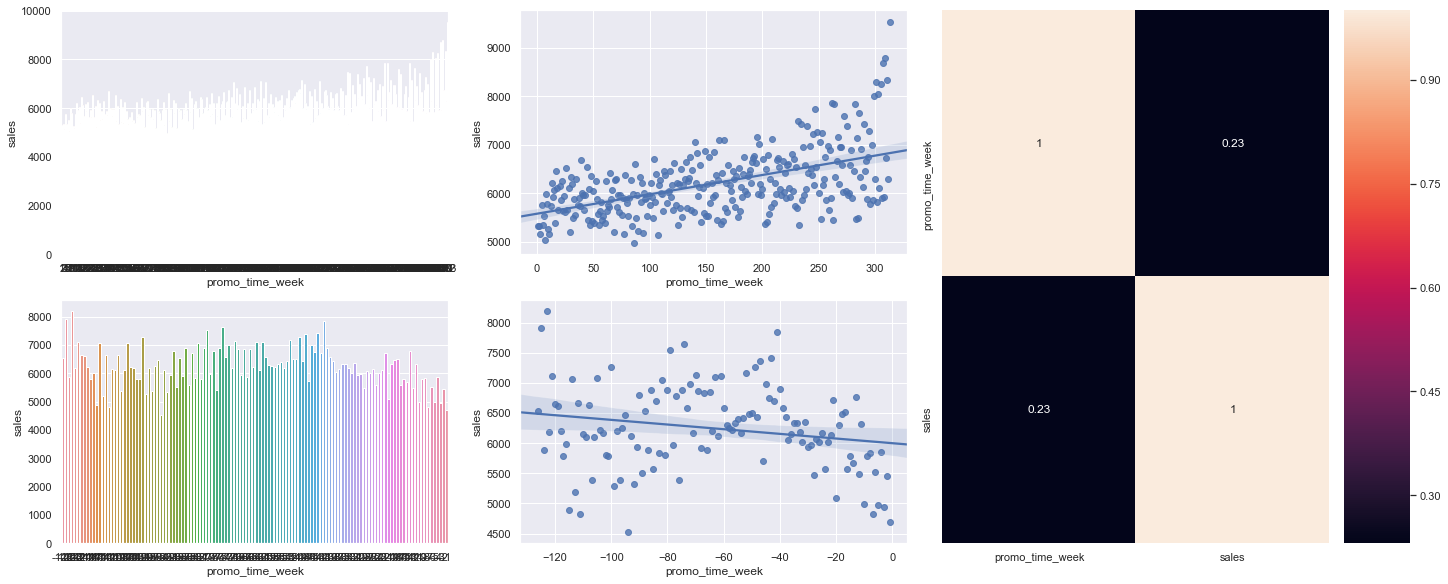

In [34]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').median().reset_index()
aux2 = aux1[aux1['promo_time_week'] > 0]
aux3 = aux1[aux1['promo_time_week'] < 0]

fig = plt.figure(constrained_layout = True)
grid = fig.add_gridspec(2,3)

fig.add_subplot(grid[0,0])
sns.barplot(x='promo_time_week', y='sales', data=aux2)

fig.add_subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

fig.add_subplot(grid[1,0])
sns.barplot(x='promo_time_week', y='sales', data=aux3)

fig.add_subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

fig.add_subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### <s> H5. Lojas com mais dias de promoção deveriam vender mais. <s>

#### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**False** Lojas com mais promoções consecutivas vendem menos.

In [35]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).median().reset_index()

,promo,promo2,sales
0,0,0,5757
1,0,1,5181
2,1,0,7950
3,1,1,7358


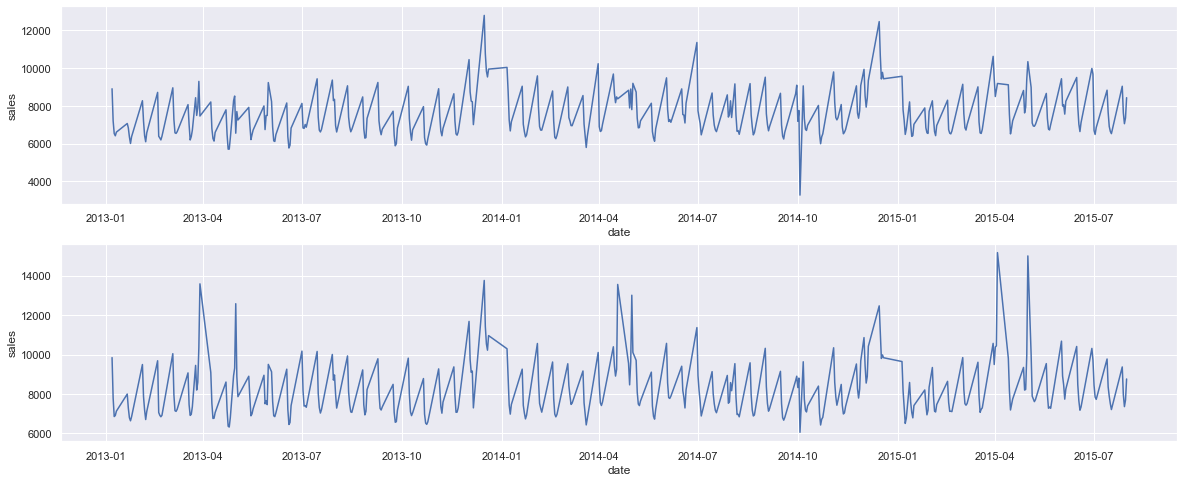

In [36]:
aux1 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 1)][['date','sales']].groupby('date').median().reset_index()
plt.subplot(2,1,1)
sns.lineplot(x='date',y='sales', data=aux1)

aux2 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 0)][['date','sales']].groupby('date').median().reset_index()
plt.subplot(2,1,2)
sns.lineplot(x='date',y='sales', data=aux2);

#### H7. As vendas no natal deveriam ser maiores.
**True**

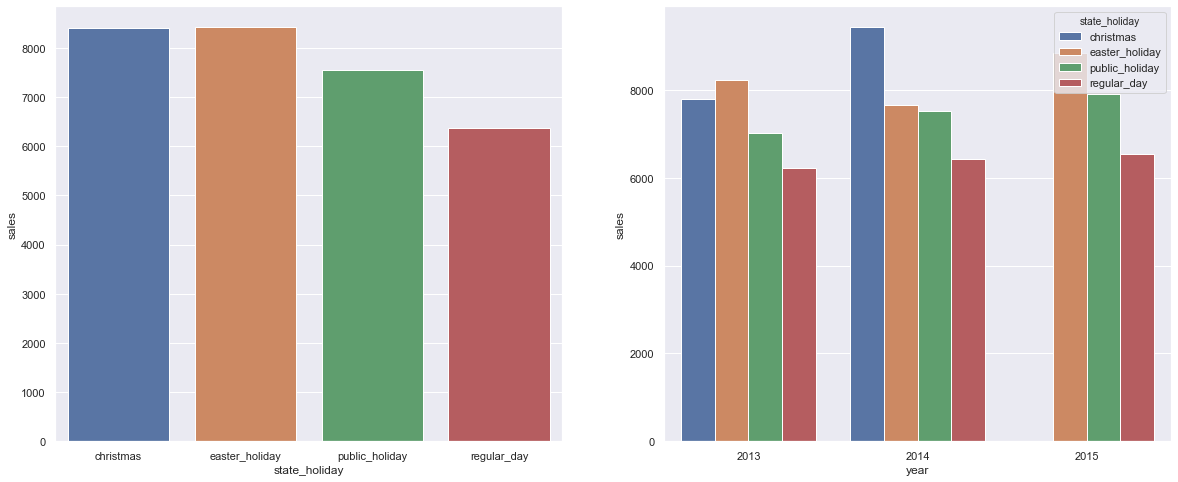

In [37]:
plt.subplot(1,2,1)
aux1 = df4[['state_holiday','sales']].groupby('state_holiday').median().reset_index()
sns.barplot(x='state_holiday',y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = df4[['year','state_holiday','sales']].groupby(['year','state_holiday']).median().reset_index()
sns.barplot(x='year',y='sales', hue='state_holiday', data=aux2);

#### H8. Lojas deveriam vender mais ao longo dos anos.
**True** A mediana de vendas do ano de 2014 é maior que 2013, porém a soma total de vendas é menor. Isso pode ser uma relação com a quantidade de registros de cada ano, ou seja, quantidade de dias abertos de 2014, pode ser menor que 2013. Validar no próximo ciclo.

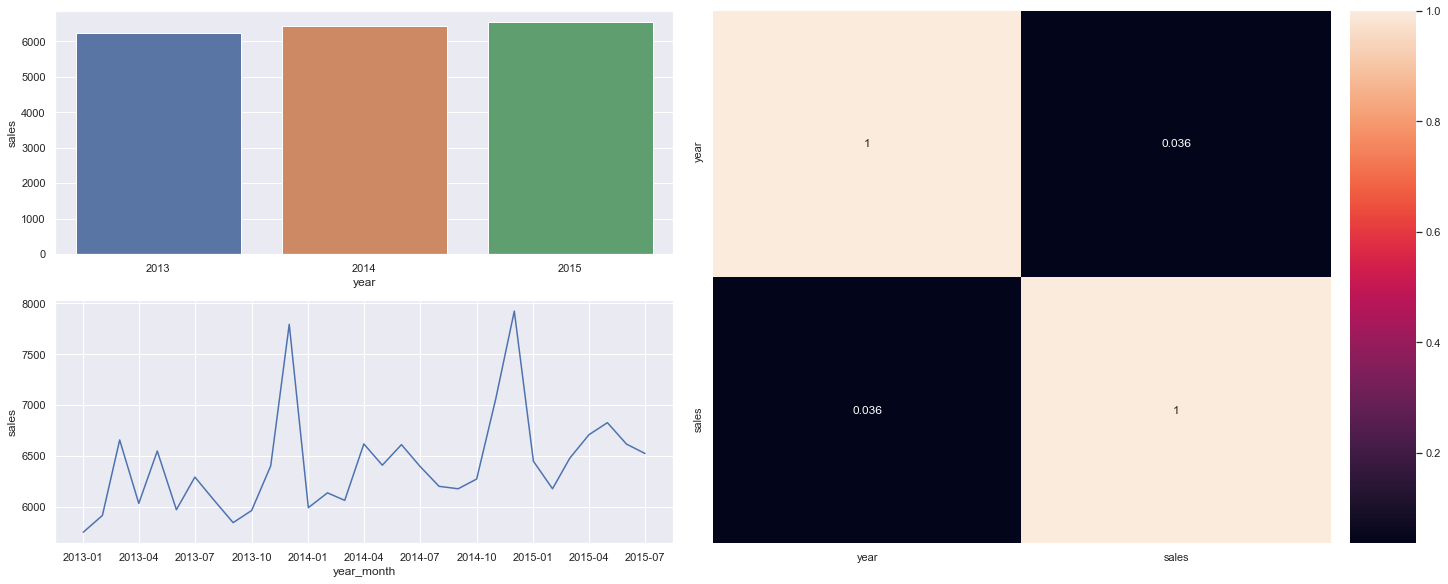

In [38]:
fig = plt.figure(constrained_layout = True)
grid = fig.add_gridspec(2,2)

fig.add_subplot(grid[0,0])
aux1 = df4[['year','sales']].groupby('year').median().reset_index()
sns.barplot(x='year',y='sales',data=aux1)

fig.add_subplot(grid[1,0])
aux2 = df4[['year','month','sales']].groupby(['year','month']).median().reset_index()
aux2['year_month'] = aux2.apply(lambda x: datetime.datetime(year=x['year'].astype('int64'), month=x['month'].astype('int64'), day=1), axis=1)
sns.lineplot(x='year_month',y='sales',data=aux2)

fig.add_subplot(grid[:,1])
sns.heatmap(df4[['year','sales']].corr(method='pearson'), annot=True);

#### H9. Lojas deveriam vender mais no segundo semestro do ano.
**True**

In [39]:
#aux1 = df4.copy()
#aux1['semester'] = aux1.apply(lambda x: 'first' if x['month'] < 6 else 'second', axis=1)
aux1 = df4[['month','sales']].groupby('month').median().reset_index()

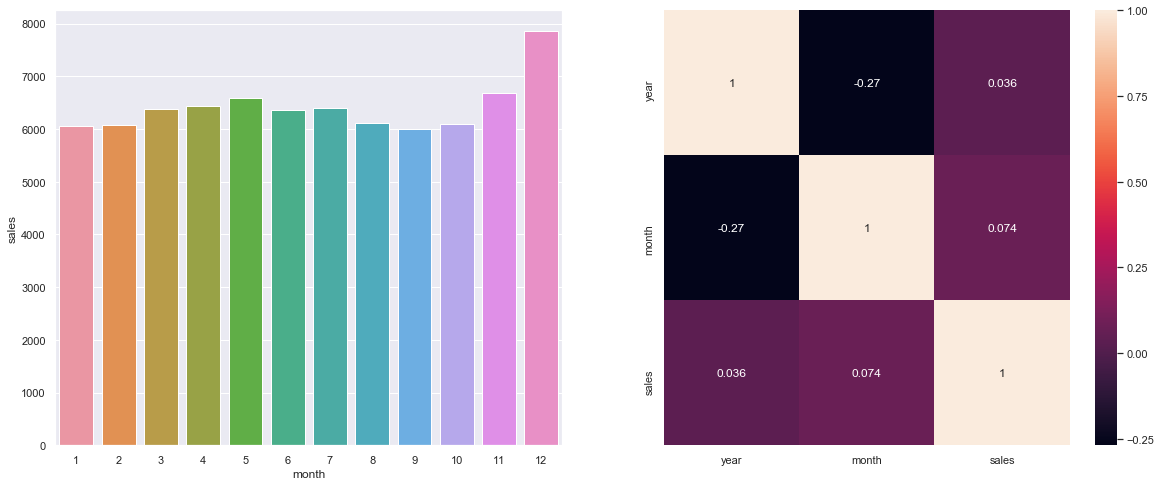

In [40]:
plt.subplot(1,2,1)
sns.barplot(x='month',y='sales',data=aux1);

plt.subplot(1,2,2)
sns.heatmap(df4[['year','month','sales']].corr(method='pearson'), annot=True);

#### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**True**

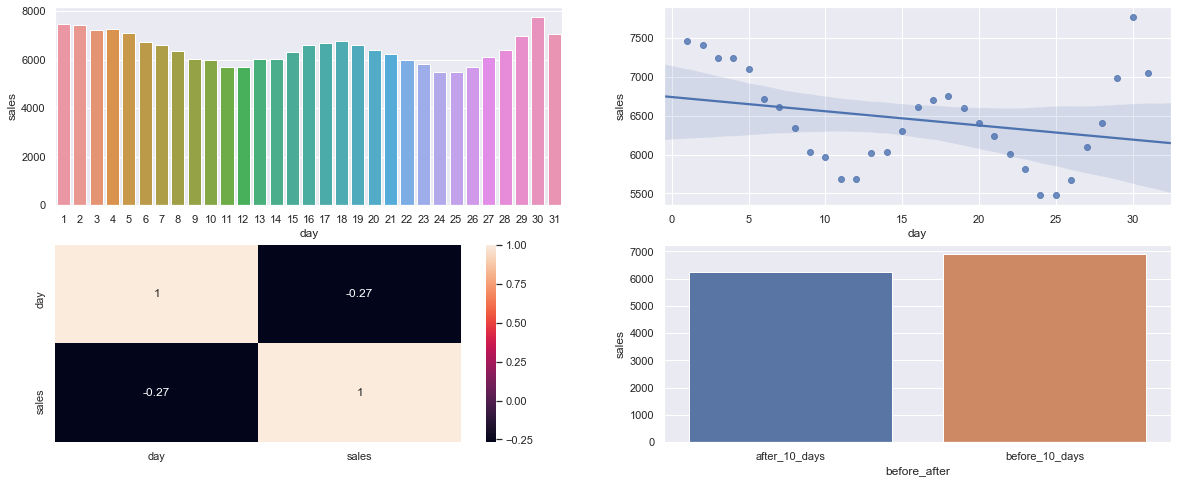

In [41]:
aux1 = df4[['day','sales']].groupby('day').median().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').median().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);

#### H11. Lojas que abrem nos finais de semana deveriam vender menos.
**True**

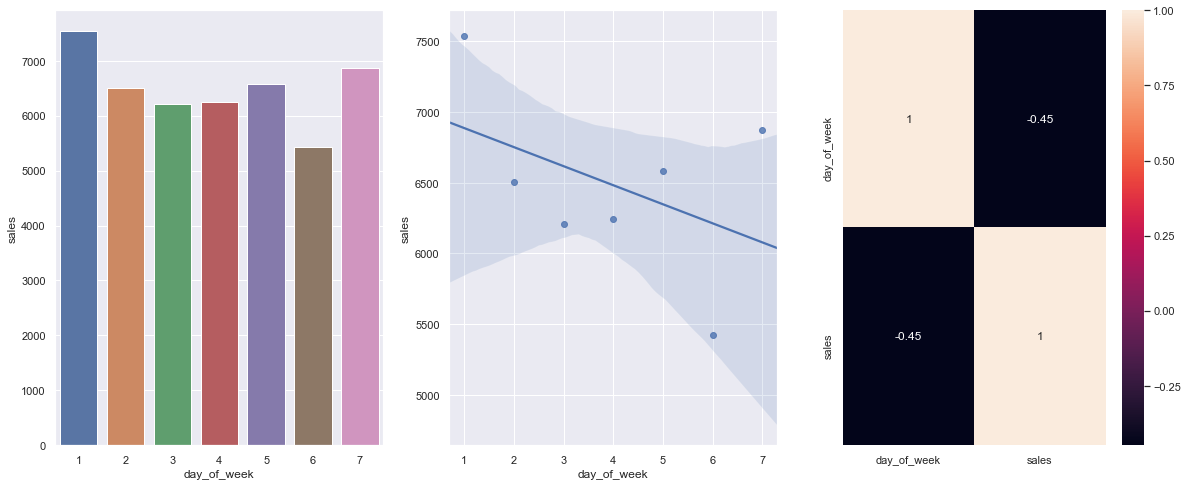

In [42]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').median().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H12. A soma das vendas em dias de feriado escolar devem ser menores que em dias normais.
**True**, exceto para os meses de julho e agosto.

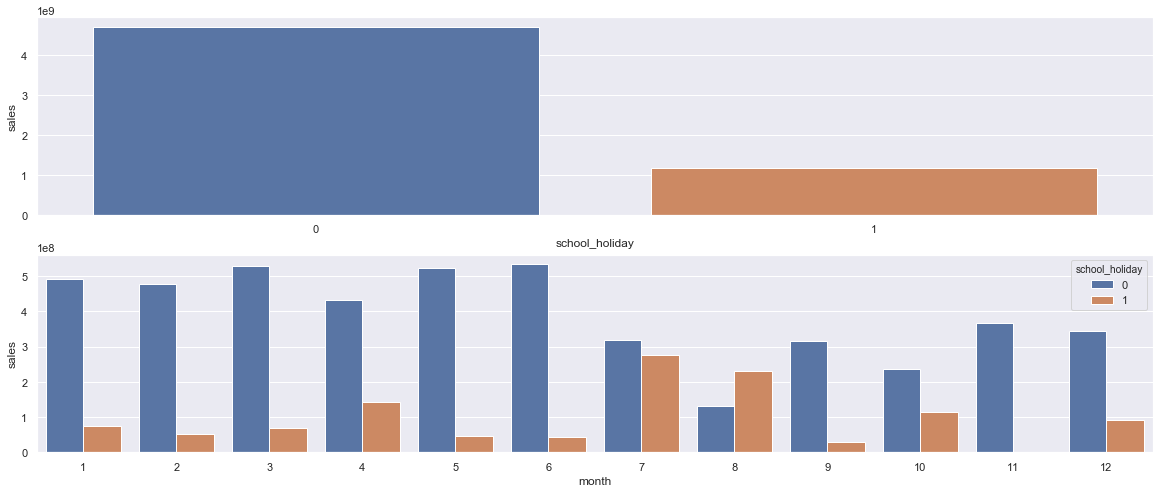

In [43]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday',y='sales',data=aux1);

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month',y='sales',hue='school_holiday', data=aux2);

### 4.2.2. Hypotheses Resume

In [44]:
tab = [['Hypotheses','Conclusion','Relevance'],
       ['H1','True','Baixa'],
       ['H2','False','Media'],
       ['H3','False','Media'],
       ['H4','True','Baixa'],
       ['H6','False','Baixa'],
       ['H7','True','Media'],
       ['H8','True','Alta'],
       ['H9','True','Alta'],
       ['H10','True','Alta'],
       ['H11','True','Alta'],
       ['H12','True','Baixa']]
print(tabulate(tab, headers='firstrow'))

Hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            True          Baixa
H2            False         Media
H3            False         Media
H4            True          Baixa
H6            False         Baixa
H7            True          Media
H8            True          Alta
H9            True          Alta
H10           True          Alta
H11           True          Alta
H12           True          Baixa


## 4.3. Multivariate Analisys

### 4.3.1 Numerical Attributes

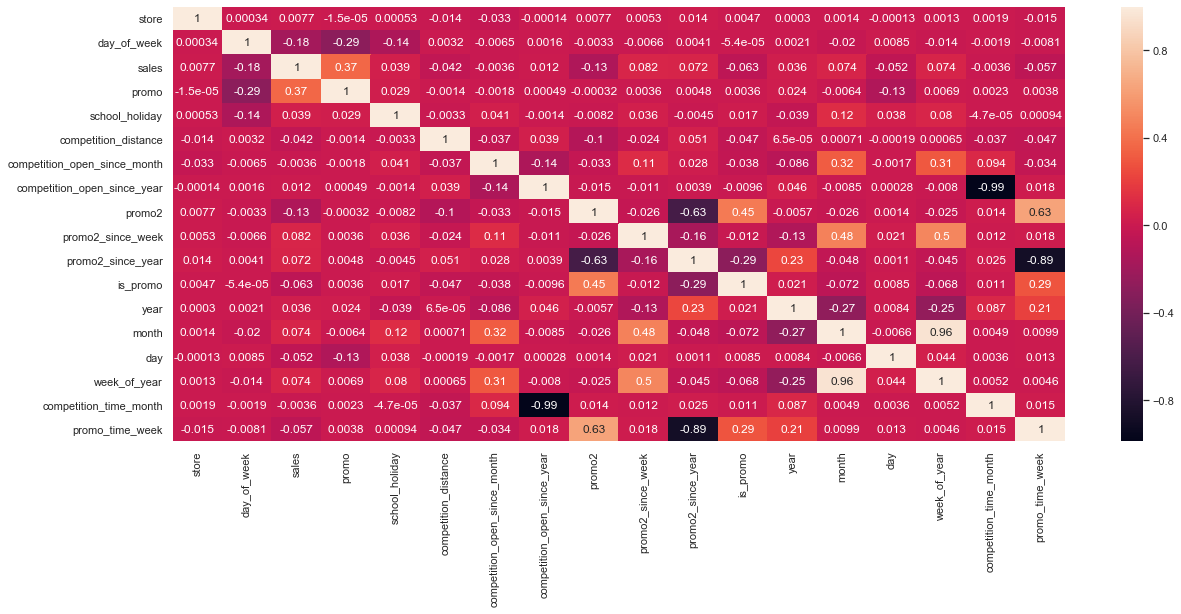

In [45]:
correlation = num_attributes2.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.1 Categorical Attributes

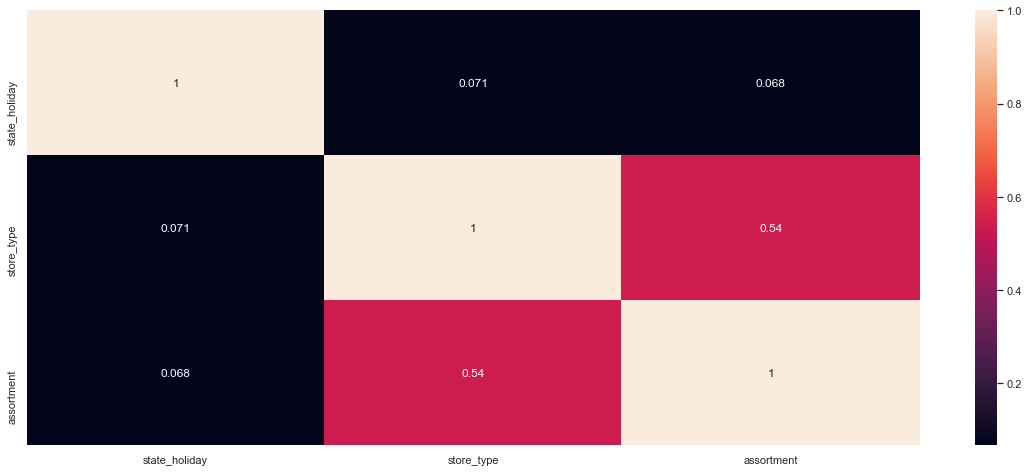

In [46]:
a = cat_attributes2.copy()

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 5.0. DATA PREPARATION

In [47]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

In [48]:
mms = MinMaxScaler()
rs = RobustScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3. Transformação

### 5.3.1 Encoding

In [49]:
# state_holiday
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment
assortment_map = {'basic': 1, 'extra': 2, 'extended': 3 }
df5['assortment'] = df5['assortment'].map(assortment_map)

### 5.3.2 Response Variable Transformation

In [50]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.2 Nature Transformation

In [51]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12))) 

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30))) 

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7))) 

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/54)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/54))) 

# 6.0. FEATURE SELECTION

In [53]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [58]:
cols_drop = ['month','day','week_of_year','day_of_week','promo_since','competition_since']
df6 = df6.drop(cols_drop, axis=1)

In [62]:
# Como nossas predições serão em relação as próximas 6 semanas, os dados de teste serão as ultimas 6 semanas registradas
## Devido ser uma predição temporal

#df6[['store','date']].groupby('store').min().reset_index() #First date

#df6[['store','date']].groupby('store').max().reset_index() #Last date

#df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7) #First date of test

Timestamp('2015-06-19 00:00:00')

In [65]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training min date: {}'.format(X_train['date'].min()))
print('Training min date: {}'.format(X_train['date'].max()))

print('\nTest min date: {}'.format(X_test['date'].min()))
print('Test min date: {}'.format(X_test['date'].max()))

Training min date: 2013-01-01 00:00:00
Training min date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test min date: 2015-07-31 00:00:00


## 6.2. Boruta Feature Selector

In [68]:
# training and test dataset boruta
X_train_n = X_train.drop(['date','sales'], axis=1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# define boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	10


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	10


### 6.2.1. Best features from Boruta

In [69]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['date','sales'], axis=1)
cols_selected_boruta = X_train.iloc[:, cols_selected]

# not selected boruta
cols_not_selected_boruta = np.setdiff1d(X_trains_fs.columns, cols_selected_boruta)

IndexError: Item wrong length 27 instead of 29.

In [70]:
##